In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.environ["KERAS_BACKEND"] = "jax"
import zipfile

In [ ]:
!mkdir sample_data2

In [ ]:
!cp "/content/drive/My Drive/Datasets/hiphop-or-world-music4.zip" /content/sample_data2/

In [ ]:
with zipfile.ZipFile("/content/sample_data2/hiphop-or-world-music4.zip") as z:
  #z.printdir()
  z.extractall("/content/sample_data2/")

In [ ]:
!rm /content/sample_data2/hiphop-or-world-music4.zip

In [ ]:
hiphop = os.listdir('sample_data2/HipHop/')
world = os.listdir('sample_data2/World/')

In [ ]:
import librosa as rosa

In [ ]:
Y = {}
SR = {}
for name in hiphop:
  _y, _sr = rosa.load(os.path.join("/content/sample_data2/HipHop/", name), sr=None)
  Y[name] = _y
  SR[name] = _sr

In [ ]:
Y2 = {}
SR2 = {}
for name in world:
  _y, _sr = rosa.load(os.path.join("/content/sample_data2/World/", name), sr=None)
  Y2[name] = _y
  SR2[name] = _sr

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# hiphop
#(1025, 259)
S = np.empty((28, 1025, 259))
for i, y in enumerate(Y.values()):
  _s = np.abs(rosa.stft(y))
  # clip it, because it breaks
  S[i,:,:] = _s[:,:259]

In [ ]:
# world
#(1025, 259)
S2 = np.empty((28, 1025, 259))
for i, y in enumerate(Y2.values()):
  _s = np.abs(rosa.stft(y))
  # clip it, because it breaks
  S2[i,:,:] = _s[:,:259]

In [ ]:
S.shape, S2.shape

((28, 1025, 259), (28, 1025, 259))

In [ ]:
# split each spectrogram in 3, each of 70 frames

In [ ]:
granularity = 70
SHipHopAugm = np.empty((84, 1025, 70))
SWorldAugm = np.empty((84, 1025, 70))
for i in range(28):
  for j in range(3):
    offset = granularity * j
    index = (i*3) + j
    SHipHopAugm[index,:,:] = S[i, :, offset:offset+granularity]
    SWorldAugm[index,:,:] = S2[i, :, offset:offset+granularity]

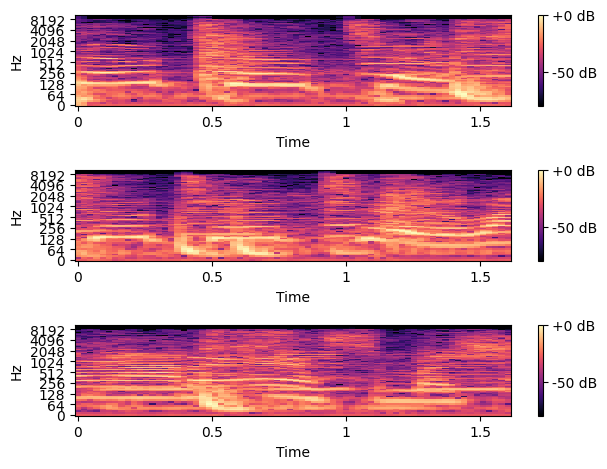

In [ ]:
# first 3 hiphop spectrograms
fig, ax = plt.subplots(nrows=3)

for i in range(3):
  granularity = 70
  offset = granularity * i
  img = rosa.display.specshow(rosa.amplitude_to_db(SHipHopAugm[i,:,:], ref=np.max), y_axis='log', x_axis='time', ax=ax[i])
  fig.colorbar(img, ax=ax[i], format="%+2.f dB")

fig.tight_layout()
plt.show()

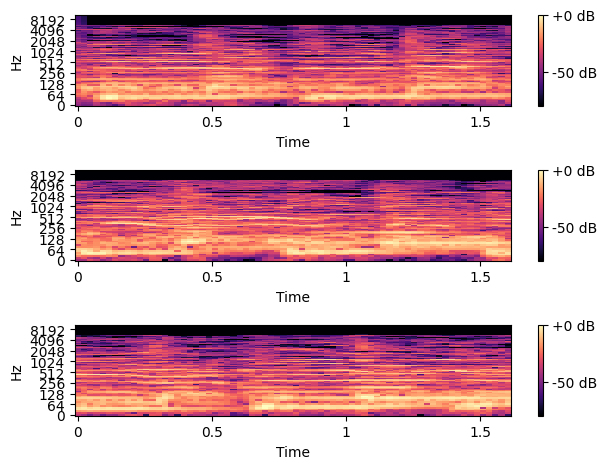

In [ ]:
# first 3 world music spectrograms
fig, ax = plt.subplots(nrows=3)

for i in range(3):
  granularity = 70
  offset = granularity * i
  img = rosa.display.specshow(rosa.amplitude_to_db(SWorldAugm[i,:,:], ref=np.max), y_axis='log', x_axis='time', ax=ax[i])
  fig.colorbar(img, ax=ax[i], format="%+2.f dB")

fig.tight_layout()
plt.show()

In [ ]:
# 1025 * 259 = 71750
SHipHopAugm2 = np.empty((84, 71750))
SWorldAugm2 = np.empty((84, 71750))

for i in range(84):
  SHipHopAugm2[i,:] = SHipHopAugm[i,:,:].reshape(-1)
  SWorldAugm2[i,:] = SWorldAugm[i,:,:].reshape(-1)
SHipHopAugm2.shape, SWorldAugm2.shape

((84, 71750), (84, 71750))

In [ ]:
Stotal = np.append(SHipHopAugm2, SWorldAugm2, axis=0)
n, c = Stotal.shape
Stotal.shape

(168, 71750)

In [ ]:
y = np.append(np.array([1] * 84), np.array([0] * 84))
y.shape

(168,)

In [ ]:
import math
from sklearn.utils import shuffle

In [ ]:
Stotal, y = shuffle(Stotal, y, random_state=0)
Stotal.shape, y.shape

((168, 71750), (168,))

In [ ]:
# compute train and test sets
b = math.floor(0.8 * 56)
b, 56 - b

(44, 12)

In [ ]:
S_train, S_test = Stotal[:b], Stotal[b:]
S_train.shape, S_test.shape

((44, 71750), (124, 71750))

In [ ]:
y_train, y_test = y[:b], y[b:]
y_train.shape, y_test.shape

((44,), (124,))

In [ ]:
import torch

In [ ]:
# make torch objects from numpy
S_train, y_train, S_test, y_test = map(torch.tensor, (S_train, y_train, S_test, y_test))

In [ ]:
S_train.shape, S_test.shape, y_train.shape, y_test.shape, type(S[0,0])

(torch.Size([44, 71750]),
 torch.Size([124, 71750]),
 torch.Size([44]),
 torch.Size([124]),
 numpy.ndarray)

# First basic one-layer logistic version

In [ ]:
def log_softmax(x):
  return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
  return log_softmax(xb @ weights + bias)

def nll(input, target):
  return -input[range(target.shape[0]), target].mean()

loss_func = nll

def accuracy(out, yb):
  preds = torch.argmax(out, dim=1)
  return (preds == yb).float().mean()

In [ ]:
weights = torch.randn(71750, 10, dtype=torch.double) / math.sqrt(71750)
weights.requires_grad_()
bias = torch.zeros(10, dtype=torch.double, requires_grad=True)

In [ ]:
# types match
weights.type(), bias.type(), S_train.type()

('torch.DoubleTensor', 'torch.DoubleTensor', 'torch.DoubleTensor')

In [ ]:
print(loss_func(model(S_train), y_train), accuracy(model(S_train), y_train).item())

tensor(6.4144, dtype=torch.float64, grad_fn=<NegBackward0>) 0.1818181872367859


In [ ]:
bs = 8  # batch size
lr = 0.5  # learning rate
epochs = 2  # how many epochs to train for

for epoch in range(epochs):
  for i in range((n - 1) // bs + 1):
    #set_trace()
    start_i = i * bs
    end_i = start_i + bs
    Sb = S_train[start_i:end_i]
    yb = y_train[start_i:end_i]
    pred = model(Sb)
    loss = loss_func(pred, yb)

    loss.backward()
    with torch.no_grad():
      weights -= weights.grad * lr
      bias -= bias.grad * lr
      weights.grad.zero_()
      bias.grad.zero_()

In [ ]:
print(loss_func(model(S_train), y_train), accuracy(model(S_train), y_train).item())

tensor(nan, dtype=torch.float64, grad_fn=<NegBackward0>) 0.5454545617103577


In [ ]:
print(loss_func(model(S_test), y_test), accuracy(model(S_test), y_test).item())

tensor(nan, dtype=torch.float64, grad_fn=<NegBackward0>) 0.4838709533214569


# Second basic version, with modules this time

In [ ]:
from torch import nn

In [ ]:
"yes" if torch.cuda.is_available() else "no"

'no'

In [ ]:
class HipHopOrWorldMusicBasicNetwork(nn.Module):
    def __init__(self):
      super().__init__()
      self.flatten = nn.Flatten()
      self.linear_relu_stack = nn.Sequential(
          # check this: there may be a too big gap between 71750 and 512
          nn.Linear(71750, 512, dtype=torch.double),
          nn.ReLU(),
          nn.Linear(512, 512, dtype=torch.double),
          nn.ReLU(),
          nn.Linear(512, 10, dtype=torch.double),
        )

    def forward(self, x):
      # crashes with this
      #x = self.flatten(x)
      logits = self.linear_relu_stack(x)
      return logits

In [ ]:
model = HipHopOrWorldMusicBasicNetwork()
print(model)

HipHopOrWorldMusicBasicNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=71750, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [ ]:
print(
    loss_func(model(S_train), y_train), accuracy(model(S_train), y_train).item(),
    "\n",
    loss_func(model(S_test), y_test), accuracy(model(S_test), y_test).item()
    )

tensor(0.1985, dtype=torch.float64, grad_fn=<NegBackward0>) 0.25 
 tensor(0.1526, dtype=torch.float64, grad_fn=<NegBackward0>) 0.13709677755832672


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [ ]:
# beginner_source\basics\quickstart_tutorial.py
# without sending objects to gpu
def train(S, y, model, loss_fn, optimizer):
  size = len(S)
  model.train()

  # batches of 1 here
  for batch, (_S, _y) in enumerate(zip(S, y)):
    pred = model(_S)
    loss = loss_fn(pred, _y)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if batch % 8 == 0:
      loss, current = loss.item(), (batch + 1) * len(_S)
      print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
epochs = 5
for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  train(S_train, y_train, model, loss_fn, optimizer)
print("Done!")

Epoch 1
-------------------------------
loss: 2.203662  [71750/   44]
loss: 12.153789  [645750/   44]
loss: 0.130227  [1219750/   44]
loss: 6.562193  [1793750/   44]
loss: 3.363667  [2367750/   44]
loss: 3.360801  [2941750/   44]
Epoch 2
-------------------------------
loss: 2.009775  [71750/   44]
loss: 1.609699  [645750/   44]
loss: 0.062426  [1219750/   44]
loss: 0.002019  [1793750/   44]
loss: 3.462738  [2367750/   44]
loss: 1.714292  [2941750/   44]
Epoch 3
-------------------------------
loss: 0.010874  [71750/   44]
loss: 1.288403  [645750/   44]
loss: 0.002186  [1219750/   44]
loss: 0.021611  [1793750/   44]
loss: 1.004493  [2367750/   44]
loss: 1.649656  [2941750/   44]
Epoch 4
-------------------------------
loss: 0.002490  [71750/   44]
loss: 0.026746  [645750/   44]
loss: 0.042158  [1219750/   44]
loss: 0.019793  [1793750/   44]
loss: 0.008169  [2367750/   44]
loss: 0.363291  [2941750/   44]
Epoch 5
-------------------------------
loss: 0.051344  [71750/   44]
loss: 0.00095

In [ ]:
print(
    loss_func(model(S_train), y_train), accuracy(model(S_train), y_train).item(),
    "\n",
    loss_func(model(S_test), y_test), accuracy(model(S_test), y_test).item()
    )

tensor(-13.4677, dtype=torch.float64, grad_fn=<NegBackward0>) 0.8863636255264282 
 tensor(-8.6051, dtype=torch.float64, grad_fn=<NegBackward0>) 0.774193525314331
